## Fraud Detection with K-Fold Cross Validation

This exercise is a follow from the previous (Fraud Detection with SMOTEENN).

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, precision_recall_curve, classification_report
from matplotlib import pyplot as plt

from imblearn.combine import SMOTEENN

In [2]:
# read data from csv.
raw_data = pd.read_csv("data/creditcard.csv")

# extract features and labels
features = raw_data.drop(["Time", "Class", "Amount"], axis=1).copy()
labels = raw_data["Class"].copy()

X = features
y = labels

# apply SMOTEENN over-sampling.
# smoteenn = SMOTEENN(sampling_strategy="auto", random_state=42)
# X, y = smoteenn.fit_sample(features, labels)

# print("Feature size after SMOTEENN: ", len(X))

In [3]:
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

forest = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    bootstrap=True
)

In [4]:
%%time

fpr_scores = []
tpr_scores = []
precision_scores = []
recall_scores = []

for (train_idx, test_idx), i in zip(cv.split(X, y), range(5)):
    print("Fold: {}".format(i + 1))

    # train the model
    forest.fit(X.iloc[train_idx], y.iloc[train_idx])

    # predict.
    prediction = forest.predict_proba(X.iloc[test_idx])[:,1]
    precision, recall, threshold = precision_recall_curve(y[test_idx], prediction)
    fpr, tpr, threshold = roc_curve(y.iloc[test_idx], prediction)

    fpr_scores.append(fpr)
    tpr_scores.append(tpr)
    precision_scores.append(precision)
    recall_scores.append(recall)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
Wall time: 4min 3s


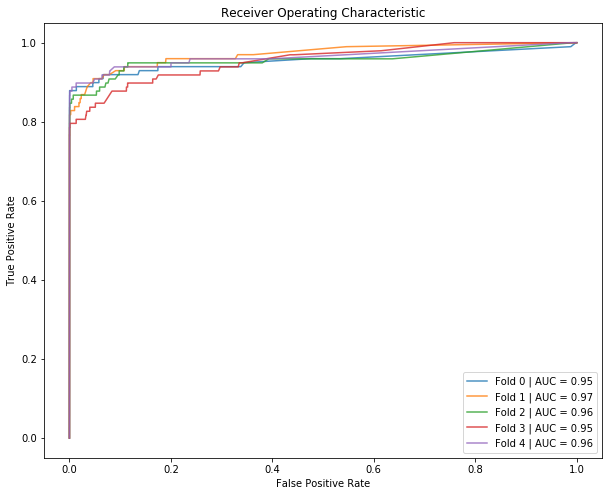

In [31]:
# Plot the ROC curve.
fig, ax = plt.subplots(figsize=(10, 8))

# plot ROC for each k-fold.
tpr_score_interpolate = []
auc_score = []
mean_fpr = np.linspace(0, 1, 100)
for i, (fpr, tpr) in enumerate(zip(fpr_scores, tpr_scores)):
    tpr_score_interpolate.append(np.interp(mean_fpr, fpr, tpr))
    tpr_score_interpolate[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    auc_score.append(roc_auc)
    ax.plot(fpr, tpr, lw=1.5, alpha=.8, label="Fold %d | AUC = %.2f" % (i, roc_auc))

# show plot.
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver Operating Characteristic")
ax.legend(loc="lower right")
plt.show()


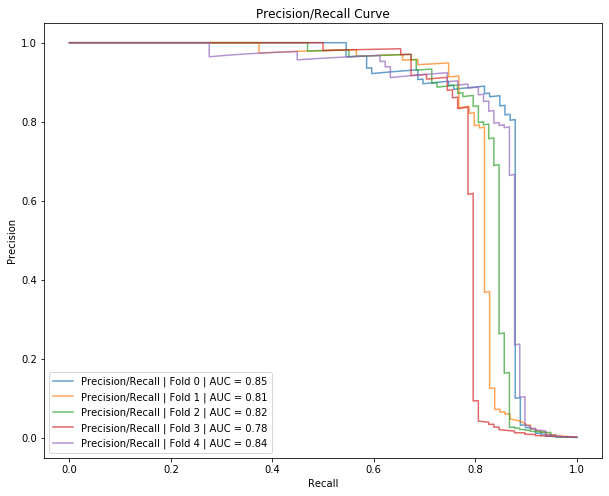

In [28]:
# Plot the Precision/Recall curve.
fig, ax = plt.subplots(figsize=(10, 8))

# plot precision/recall for each k-fold.
precision_score_interpolate = []
auc_scores = []
mean_recall = np.linspace(0, 1, 100)

for i, (recall, precision) in enumerate(zip(recall_scores, precision_scores)):
    precision_score_interpolate.append(np.interp(mean_recall, recall, precision))
    precision_score_interpolate[-1][0] = 0.0
    
    auc_score = auc(recall, precision)
    auc_scores.append(auc_score)
    
    ax.plot(recall, precision, lw=1.5, alpha=.7, label="Fold %d | AUC = %.2f" % (i, auc_score))


# show plot.
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision/Recall Curve")
ax.legend(loc="lower left")
plt.show()